# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [137]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import sys

sys.path.append("./functions/")
import preprocess
import model

% matplotlib inline
from IPython.display import display_html

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectPercentile
from sklearn.linear_model import LinearRegression


## 1. Data Understanding

* We will understand more about out datasets in this section.
* Some information about the columns.
* How many columns and rows.
* Visualize The Persons Number of Different Age and Income to see the big picture.

In [84]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [85]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [86]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


In [87]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [88]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In [89]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [90]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [91]:
portfolio.shape

(10, 6)

In [92]:
profile.shape

(17000, 5)

In [93]:
transcript.shape

(306534, 4)

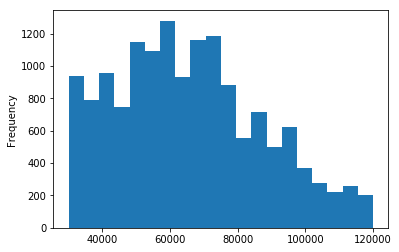

In [94]:
profile.income.plot(kind="hist", bins=20);

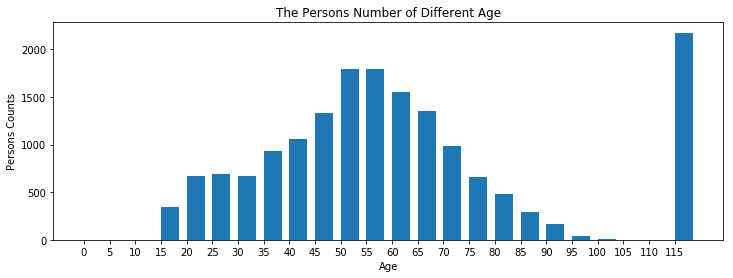

In [95]:
count_by_agegroup=profile.groupby(pd.cut(profile['age'], np.arange(0, 118+5, 5)))['id'].count()
plt.figure(figsize=(12,4))
plt.bar(np.arange(0, 118, 5),count_by_agegroup,width=3.5, align='edge')
plt.xticks(np.arange(0, 118, 5))
plt.xlabel('Age')
plt.ylabel('Persons Counts')
plt.title('The Persons Number of Different Age')
plt.show()

## 2. Preprocessing Data

* Portfolio data: Get the different channel.
* Profile data: Convert the attribute became_member_on to datetime type, Deal with missing values in gender and Fix the income.
* Transcript data: Extract value

In [96]:
# extract all channels
channels = set()
for channel in portfolio.channels:
    channels.update(set(channel))
    
channels

{'email', 'mobile', 'social', 'web'}

In [97]:
# split the channel into different attribute
for channel in channels:
    portfolio[channel] = portfolio.channels.apply(lambda x: channel in x).map({True:1, False: 0})

portfolio.head()

,channels,difficulty,duration,id,offer_type,reward,social,web,mobile,email
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,0,1,1
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,0,1,1,1
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,0,1,1,1
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,0,1,0,1


In [98]:
# convert the datatype into datetime
profile["became_member_on"] = pd.to_datetime(profile.became_member_on.apply(str))
profile["became_member_year"] = profile.became_member_on.dt.year
profile["became_member_month"] = profile.became_member_on.dt.month

In [99]:
# parse the information about the gender
profile["gender"] = profile.gender.map({"None":np.nan, "F":"Female", "M":"Male", "O": "Other"})

In [100]:
# fix the abnormal values about the attribute age
profile.loc[profile.age == 118, "age"] = np.nan
profile.head()

,age,became_member_on,gender,id,income,became_member_year,became_member_month
0,NaN,2017-02-12,NaN,68be06ca386d4c31939f3a4f0e3dd783,NaN,2017,2
1,55.0,2017-07-15,Female,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7
2,NaN,2018-07-12,NaN,38fe809add3b4fcf9315a9694bb96ff5,NaN,2018,7
3,75.0,2017-05-09,Female,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,5
4,NaN,2017-08-04,NaN,a03223e636434f42ac4c3df47e8bac43,NaN,2017,8


In [101]:
# split the income into four different level
profile["income_fix"] = \
    pd.qcut(profile.income, 4, labels=["low", "medium", "medium_high", "high"])

# reset the category order and fill the missing value with unknown
profile.income_fix.cat.set_categories(["unknown", "low", "medium", "medium_high", "high"], 
                                      ordered=True, inplace=True)
profile.income_fix.fillna("unknown", inplace=True)

In [102]:
# deal with age missing value
profile["age_fix"] = pd.qcut(profile.age, 3, labels=["young", "middle", "old"])

profile.age_fix.fillna("middle", inplace=True)

In [103]:
# fill the missing value of the gender
profile.gender.fillna("unknown", inplace=True)

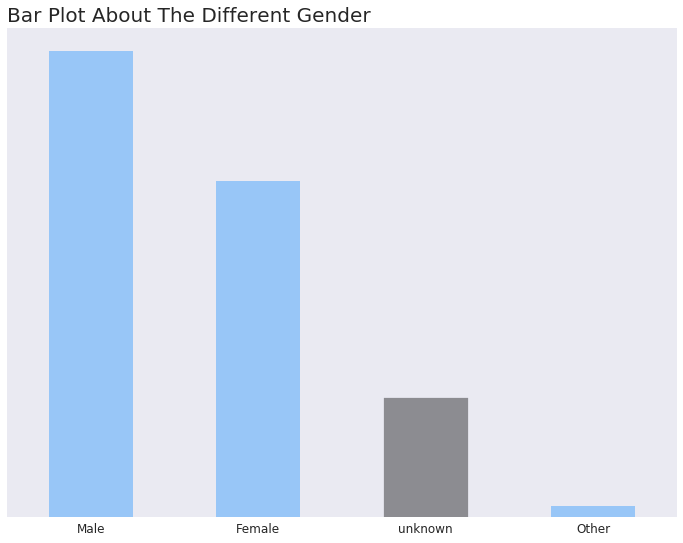

In [104]:
with sns.axes_style("dark"), sns.plotting_context("paper", font_scale=1.5):
    plt.figure(figsize=(12, 9))
    ax = plt.subplot()
    profile.gender.value_counts(dropna=False).plot(kind="bar", color="#98C6F7", rot=0)
    
    ax.tick_params(axis="y", labelleft=False)
    ax.patches[2].set_color("#8C8C91")
    
    ax.set_title("Bar Plot About The Different Gender", loc="left", fontsize=20)

In [105]:
# get the all kinds of the transcript type value
transcript_type = set()
for transcripts in transcript.value:
    transcript_type.update(set(transcripts.keys()))
transcript_type

{'amount', 'offer id', 'offer_id', 'reward'}

In [106]:
for i in ["amount", "reward"]:
    transcript[i] = transcript.value.apply(lambda x: x[i] if i in x else np.nan)

In [107]:
transcript["offer_id"] = transcript.value.apply(preprocess.parse_offer_id)
transcript["event"] = transcript.event.map({
    "offer completed": "offer_completed", "offer received": "offer_received",
    "offer viewed":"offer_viewed"
})

In [108]:
transcript.head()

,event,person,time,value,amount,reward,offer_id
0,offer_received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,offer_received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,offer_received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},NaN,NaN,2906b810c7d4411798c6938adc9daaa5
3,offer_received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4
4,offer_received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},NaN,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0


In [109]:
# merge the data
data = transcript.merge(profile, how="left", left_on="person", right_on="id", validate="m:1")
data.drop("id", inplace=True, axis=1)
data = data.merge(portfolio, how="left", left_on="offer_id", right_on="id", validate="m:1",
                 suffixes=("_transcript", "_portfolia"))
data.drop("id", inplace=True, axis=1)

In [110]:
data.head(2)

,event,person,time,value,amount,reward_transcript,offer_id,age,became_member_on,gender,...,age_fix,channels,difficulty,duration,offer_type,reward_portfolia,social,web,mobile,email
0,offer_received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,75.0,2017-05-09,Female,...,old,"[web, email, mobile]",5.0,7.0,bogo,5.0,0.0,1.0,1.0,1.0
1,offer_received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,2017-08-04,unknown,...,middle,"[web, email]",20.0,10.0,discount,5.0,0.0,1.0,0.0,1.0


In [111]:
data["offer_type_fix"] = data.offer_type.fillna("No_offer")
data["event_fix"] = data.event
data.loc[data.offer_id.isnull(), "event_fix"] = "No_offer_completed"

## 3. Exploratory Data Analysis

In [112]:
demograph_info = preprocess.group_size(data.loc[data.event_fix.isin(["offer_completed", "No_offer_completed"])],
                                       ["income_fix", "age_fix", "gender"], label="value")
demograph_info.columns = ["income", "age", "gender", "value"]

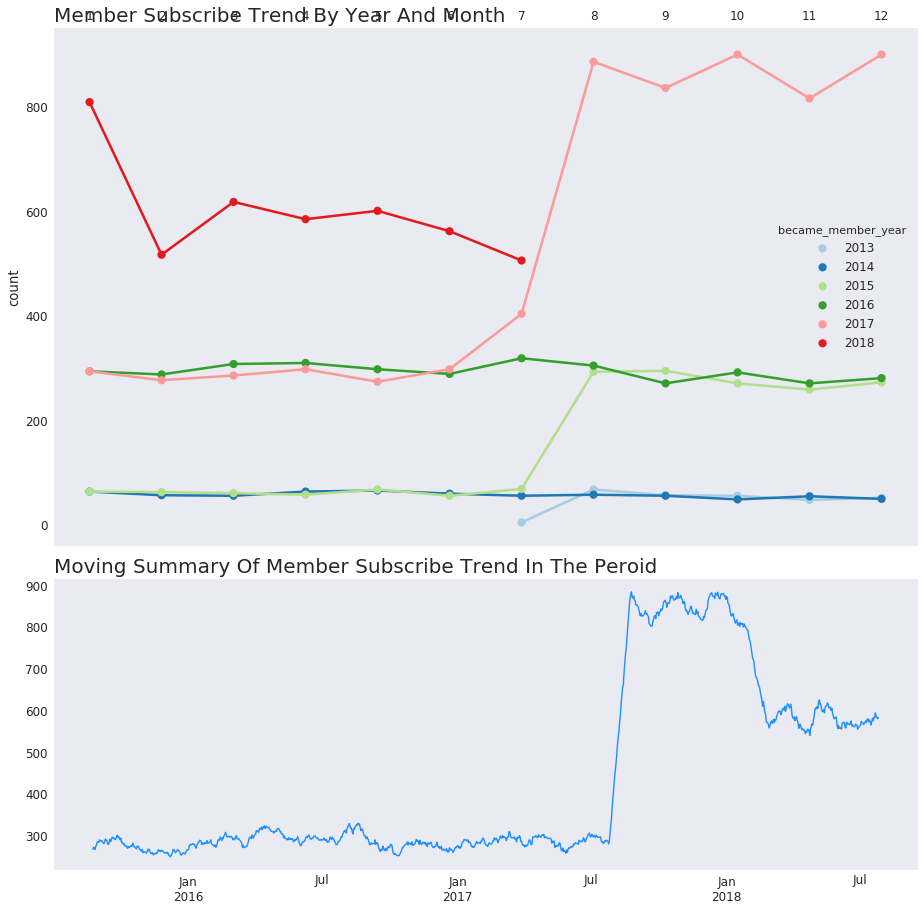

In [113]:
member_amount = preprocess.members_with_time(profile.became_member_on.value_counts(), column="count", method="sum",
                                    start=profile.became_member_on.min(), end=profile.became_member_on.max()
                                    )
# deal with the income value
with warnings.catch_warnings(),sns.axes_style("dark"), sns.plotting_context("paper", font_scale=1.5):
    warnings.simplefilter("ignore")
    
    plt.figure(1, figsize=(12, 9))
    ax1 = plt.axes([0, .1, 1, .45])
    ax2 = plt.axes([0, .6, 1, .8])

    member_amount["count"].plot(kind="line", ax=ax1, color="dodgerblue")
    sns.pointplot(x="became_member_month", y="count", hue="became_member_year",
                  ax=ax2, palette=sns.color_palette("Paired"),
             data=preprocess.group_size(profile, ["became_member_year", "became_member_month"]))

    ax1.set_title("Moving Summary Of Member Subscribe Trend In The Peroid", fontsize=20, loc="left")
    ax2.tick_params(axis="x", bottom=False, labelbottom=False, top=True, labeltop=True)
    ax2.set_xlabel("")
    ax2.set_title("Member Subscribe Trend By Year And Month", fontsize=20, loc="left")


    plt.show()

In [114]:
demograph_info = preprocess.group_size(data.loc[data.event_fix.isin(["offer_completed", "No_offer_completed"])],
                                       ["income_fix", "age_fix", "gender"], label="value")
demograph_info.columns = ["income", "age", "gender", "value"]

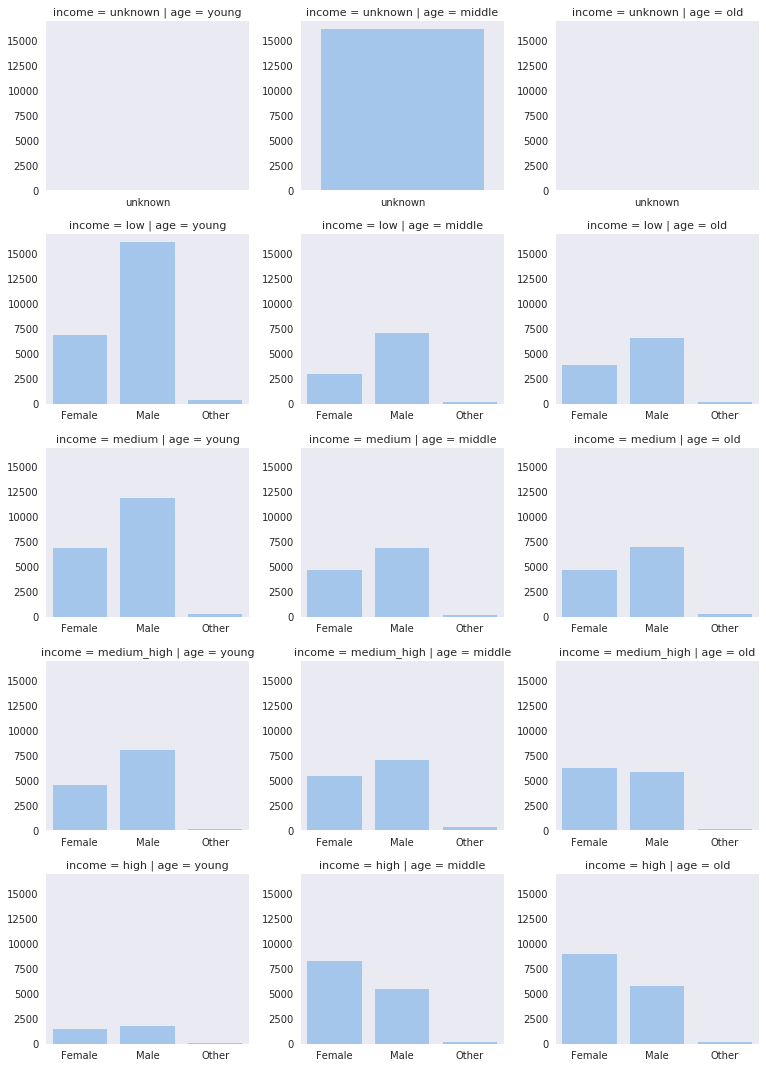

In [115]:
with sns.axes_style("dark"), sns.plotting_context("notebook", font_scale=1):
    g = sns.FacetGrid(demograph_info, row="income", col="age", aspect=1.2, sharex="row")
    g.map_dataframe(sns.barplot, x="gender", y="value", color="#98c6f7")

    plt.show()

In [116]:
(profile.groupby(["income_fix", "gender"]).size() / profile.shape[0]).nlargest(7)

income_fix   gender 
low          Male       0.155765
medium       Male       0.141529
unknown      unknown    0.127941
high         Female     0.122529
medium_high  Male       0.117412
             Female     0.092471
high         Male       0.084353
dtype: float64

In [117]:
demograph_offer = preprocess.group_size(data.loc[data.event == "offer_completed"], 
                                             ["income_fix", "age_fix", "gender", "offer_type_fix"], label="value")
demograph_offer.columns = ["income", "age", "gender", "offer_type", "value"]

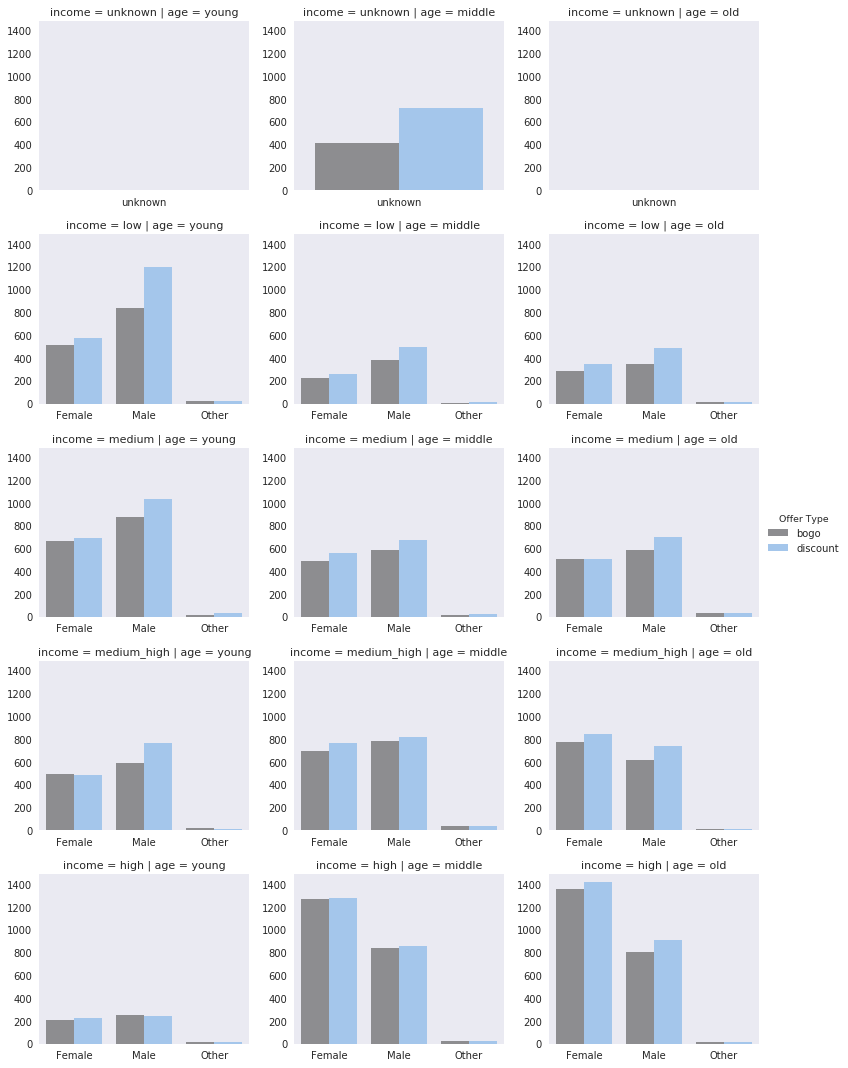

In [118]:
with sns.axes_style("dark"), sns.plotting_context("notebook", font_scale=1):
    g = sns.FacetGrid(demograph_offer, row="income", col="age", aspect=1.2, sharex="row")
    g.map_dataframe(sns.barplot, x="gender", y="value", hue="offer_type", palette=["#8c8c91", "#98c6f7"])
    g.add_legend(title="Offer Type")
    plt.show()

In [119]:
demograph_offer.nlargest(10, "value")

,income,age,gender,offer_type,value
69,high,old,Female,discount,1417
68,high,old,Female,bogo,1362
63,high,middle,Female,discount,1283
62,high,middle,Female,bogo,1275
5,low,young,Male,discount,1200
23,medium,young,Male,discount,1033
71,high,old,Male,discount,913
22,medium,young,Male,bogo,878
65,high,middle,Male,discount,858
51,medium_high,old,Female,discount,843


In [120]:
# get the informational promotion vaue
all_info = preprocess.merge_data(
        transcript, transcript, condition="event", cond_value1="offer_viewed",
        cond_value2="offer_received", columns1=["person", "offer_id", "time"], 
        columns2=["person", "offer_id", "time", "reward"], how="left",
        on=["person", "offer_id"], suffixes=("_viewed", "_received"),
         portfolio=portfolio, portfolio_suffix=("_info", "_offer")
    )

# Store the data value with the informational data
info_completion = all_info.loc[(all_info.offer_type == "informational")]

In [121]:
# merge the transaction data after the informational promotion
validate_info_data = preprocess.merge_data(
    transcript.loc[transcript.offer_id.isnull(), ["person", "time", "amount"]],
    info_completion.loc[:, ["person", "offer_id", "time_received", "time_viewed",
                            "duration"]], portfolio_suffix=("_purchase", "_info"),
    on="person"
    )


In [122]:
# filter the purchase data after the non informational promotion
after_info = validate_info_data.loc[validate_info_data.apply(preprocess.info_filter, axis=1)]

# unify the finish time :change the time_viewed to the time_completed
after_info = after_info.rename({"time_viewed" : "time_completed"}, axis=1)

In [123]:
# get the offer_compeletion
all_offer = pd.merge(
    transcript.loc[transcript.event == "offer_received", ["person", "offer_id", "time"]],
    transcript.loc[transcript.event == "offer_completed", ["person", "offer_id", "time", "reward"]],
    how="left", on=["person", "offer_id"], suffixes=("_received", "_completed")
)


all_offer = all_offer.merge(
    portfolio, how="left", left_on="offer_id", right_on="id", suffixes=("_complete", "_offer")
)

# clean the data value about the informational data, just keep the values BOGO | discount data
offer_completion = all_offer.loc[(all_offer.offer_type != "informational")]

In [124]:
# filter the value with the validate offer duration
offer_completion = offer_completion.loc[offer_completion.apply(
            lambda x: 0 <= x["time_completed"] - x["time_received"] <= x["duration"], axis=1)]

In [125]:
# merge the transaction data after the non informational promotion
validate_offer_data = pd.merge(
        transcript.loc[transcript.offer_id.isnull(), ["person", "time", "amount"]],
        offer_completion.loc[:, ["person", "offer_id", "time_received", 
                                 "time_completed", "duration", "reward_complete"]],
        on="person", how="left", suffixes=("_purchase", "_offer")
    )

In [126]:
after_offer = validate_offer_data.loc[validate_offer_data.apply(lambda x: (x["time"] > x["time_completed"] and \
                                                 (x["time_received"] + x["duration"] <= x["time"])), axis=1)]

In [127]:
after_promotion = pd.concat([after_offer[["person", "offer_id", "time", "time_completed", "amount", "reward_complete"]], 
           after_info[["person", "offer_id", "time", "time_completed", "amount"]]], 
              sort=False).reset_index(drop=1)

In [128]:

# merge the all data
# firstly merge the profile data
after_promotion = preprocess.merge_data(
        profile.rename({"id":"person"}, axis=1).iloc[:, np.r_[1:4, 5:9]],after_promotion, how="right", on="person", portfolio_suffix=("_x", "_y")
    )
# secondly merge with the porfolio data
after_promotion = preprocess.merge_data(
        portfolio.rename({"id":"offer_id"}, axis=1),
        after_promotion, how="right", on="offer_id", portfolio_suffix=("_x", "_y")
    )

## 4. Build a Model

We want the company make a profile to keep running So, we want to know how much the promotion affects the profile.

In [129]:
after_promotion.head()

,channels,difficulty,duration,offer_id,offer_type,reward,social,web,mobile,email,...,gender,person,became_member_year,became_member_month,income_fix,age_fix,time,time_completed,amount,reward_complete
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,0,1,1,...,Male,4b0da7e80e5945209a1fdddfe813dbe0,2017,9,high,old,684,510.0,40.96,10.0
1,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,0,1,1,...,Female,f8aedd0cbea0419c806842b4265b82e5,2016,8,medium_high,old,390,168.0,14.87,10.0
2,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,0,1,1,...,Female,f8aedd0cbea0419c806842b4265b82e5,2016,8,medium_high,old,402,168.0,13.93,10.0
3,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,0,1,1,...,Female,f8aedd0cbea0419c806842b4265b82e5,2016,8,medium_high,old,444,168.0,17.48,10.0
4,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,0,1,1,...,Female,f8aedd0cbea0419c806842b4265b82e5,2016,8,medium_high,old,462,168.0,15.87,10.0


In [130]:
# get the copy of the promotion data
raw_data = after_promotion.drop(["offer_id", "person"], axis=1)

# get the time interval between the promotion completed and the transaction time
raw_data["time_interval"] = raw_data["time"] - raw_data["time_completed"]
raw_data.drop(["time", "time_completed"], axis=1, inplace=True)

In [131]:
raw_data.head(2)

,channels,difficulty,duration,offer_type,reward,social,web,mobile,email,became_member_on,gender,became_member_year,became_member_month,income_fix,age_fix,amount,reward_complete,time_interval
0,"[email, mobile, social]",10,7,bogo,10,1,0,1,1,2017-09-09,Male,2017,9,high,old,40.96,10.0,174.0
1,"[email, mobile, social]",10,7,bogo,10,1,0,1,1,2016-08-11,Female,2016,8,medium_high,old,14.87,10.0,222.0


In [132]:
X = raw_data.drop("amount", axis=1)
y = raw_data["amount"].apply(np.log2)

In [133]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=.25, random_state=42, shuffle=True)

In [134]:
pipeline = Pipeline([
    ("feature_select", SelectPercentile()),
    ("model", LinearRegression(n_jobs=2))
])
params = {
    "feature_select__percentile":[70, 90, 100],
    "model__normalize":[True, False],
}

cv = GridSearchCV(pipeline, param_grid=params, cv=3, n_jobs=2)

In [135]:
# train the basic model
cv = model.model_built(pipeline, params, train_X, train_y, test_X=test_X,test_y=test_y, model_name="LinearRegression",report=True)

JoblibValueError: JoblibValueError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
/opt/conda/lib/python3.6/runpy.py in _run_module_as_main(mod_name='ipykernel_launcher', alter_argv=1)
    188         sys.exit(msg)
    189     main_globals = sys.modules["__main__"].__dict__
    190     if alter_argv:
    191         sys.argv[0] = mod_spec.origin
    192     return _run_code(code, main_globals, None,
--> 193                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py')
    194 
    195 def run_module(mod_name, init_globals=None,
    196                run_name=None, alter_sys=False):
    197     """Execute a module's code without importing it

...........................................................................
/opt/conda/lib/python3.6/runpy.py in _run_code(code=<code object <module> at 0x7f631852cd20, file "/...3.6/site-packages/ipykernel_launcher.py", line 5>, run_globals={'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/opt/conda/lib/python3.6/site-packages/__pycache__/ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py'>, ...}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), pkg_name='', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x7f631852cd20, file "/...3.6/site-packages/ipykernel_launcher.py", line 5>
        run_globals = {'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/opt/conda/lib/python3.6/site-packages/__pycache__/ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py'>, ...}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py in <module>()
     11     # This is added back by InteractiveShellApp.init_path()
     12     if sys.path[0] == '':
     13         del sys.path[0]
     14 
     15     from ipykernel import kernelapp as app
---> 16     app.launch_new_instance()

...........................................................................
/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    492         if self.poller is not None:
    493             self.poller.start()
    494         self.kernel.start()
    495         self.io_loop = ioloop.IOLoop.current()
    496         try:
--> 497             self.io_loop.start()
        self.io_loop.start = <bound method PollIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    498         except KeyboardInterrupt:
    499             pass
    500 
    501 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
/opt/conda/lib/python3.6/site-packages/tornado/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    827                         self._timeouts = [x for x in self._timeouts
    828                                           if x.callback is not None]
    829                         heapq.heapify(self._timeouts)
    830 
    831                 for i in range(ncallbacks):
--> 832                     self._run_callback(self._callbacks.popleft())
        self._run_callback = <bound method IOLoop._run_callback of <zmq.eventloop.ioloop.ZMQIOLoop object>>
        self._callbacks.popleft = <built-in method popleft of collections.deque object>
    833                 for timeout in due_timeouts:
    834                     if timeout.callback is not None:
    835                         self._run_callback(timeout.callback)
    836                 # Closures may be holding on to a lot of memory, so allow

...........................................................................
/opt/conda/lib/python3.6/site-packages/tornado/ioloop.py in _run_callback(self=<zmq.eventloop.ioloop.ZMQIOLoop object>, callback=functools.partial(<function wrap.<locals>.null_wrapper at 0x7f62b00bbbf8>))
    600         """Runs a callback with error handling.
    601 
    602         For use in subclasses.
    603         """
    604         try:
--> 605             ret = callback()
        ret = undefined
        callback = functools.partial(<function wrap.<locals>.null_wrapper at 0x7f62b00bbbf8>)
    606             if ret is not None:
    607                 from tornado import gen
    608                 # Functions that return Futures typically swallow all
    609                 # exceptions and store them in the Future.  If a Future

...........................................................................
/opt/conda/lib/python3.6/site-packages/tornado/stack_context.py in null_wrapper(*args=(), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = ()
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
/opt/conda/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in <lambda>()
    531             return
    532 
    533         if state & self.socket.events:
    534             # events still exist that haven't been processed
    535             # explicitly schedule handling to avoid missing events due to edge-triggered FDs
--> 536             self.io_loop.add_callback(lambda : self._handle_events(self.socket, 0))
    537 
    538     def _init_io_state(self):
    539         """initialize the ioloop event handler"""
    540         with stack_context.NullContext():

...........................................................................
/opt/conda/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=0)
    445             return
    446         zmq_events = self.socket.EVENTS
    447         try:
    448             # dispatch events:
    449             if zmq_events & zmq.POLLIN and self.receiving():
--> 450                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    451                 if not self.socket:
    452                     return
    453             if zmq_events & zmq.POLLOUT and self.sending():
    454                 self._handle_send()

...........................................................................
/opt/conda/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    475             else:
    476                 raise
    477         else:
    478             if self._recv_callback:
    479                 callback = self._recv_callback
--> 480                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    481         
    482 
    483     def _handle_send(self):
    484         """Handle a send event."""

...........................................................................
/opt/conda/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    427         close our socket."""
    428         try:
    429             # Use a NullContext to ensure that all StackContexts are run
    430             # inside our blanket exception handler rather than outside.
    431             with stack_context.NullContext():
--> 432                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    433         except:
    434             gen_log.error("Uncaught exception in ZMQStream callback",
    435                           exc_info=True)
    436             # Re-raise the exception so that IOLoop.handle_callback_exception

...........................................................................
/opt/conda/lib/python3.6/site-packages/tornado/stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
/opt/conda/lib/python3.6/site-packages/ipykernel/kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    278         if self.control_stream:
    279             self.control_stream.on_recv(self.dispatch_control, copy=False)
    280 
    281         def make_dispatcher(stream):
    282             def dispatcher(msg):
--> 283                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    284             return dispatcher
    285 
    286         for s in self.shell_streams:
    287             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
/opt/conda/lib/python3.6/site-packages/ipykernel/kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': '# train the basic model\ncv = model.model_built(p...est_y, model_name="LinearRegression",report=True)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2019, 8, 22, 17, 47, 54, 652649, tzinfo=tzlocal()), 'msg_id': 'a469f8db88254653adbfee94e2ea451a', 'msg_type': 'execute_request', 'session': '895327d61868403b8d189379e731f8d0', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': 'a469f8db88254653adbfee94e2ea451a', 'msg_type': 'execute_request', 'parent_header': {}})
    228             self.log.warning("Unknown message type: %r", msg_type)
    229         else:
    230             self.log.debug("%s: %s", msg_type, msg)
    231             self.pre_handler_hook()
    232             try:
--> 233                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'895327d61868403b8d189379e731f8d0']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': '# train the basic model\ncv = model.model_built(p...est_y, model_name="LinearRegression",report=True)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2019, 8, 22, 17, 47, 54, 652649, tzinfo=tzlocal()), 'msg_id': 'a469f8db88254653adbfee94e2ea451a', 'msg_type': 'execute_request', 'session': '895327d61868403b8d189379e731f8d0', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': 'a469f8db88254653adbfee94e2ea451a', 'msg_type': 'execute_request', 'parent_header': {}}
    234             except Exception:
    235                 self.log.error("Exception in message handler:", exc_info=True)
    236             finally:
    237                 self.post_handler_hook()

...........................................................................
/opt/conda/lib/python3.6/site-packages/ipykernel/kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'895327d61868403b8d189379e731f8d0'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': '# train the basic model\ncv = model.model_built(p...est_y, model_name="LinearRegression",report=True)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2019, 8, 22, 17, 47, 54, 652649, tzinfo=tzlocal()), 'msg_id': 'a469f8db88254653adbfee94e2ea451a', 'msg_type': 'execute_request', 'session': '895327d61868403b8d189379e731f8d0', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': 'a469f8db88254653adbfee94e2ea451a', 'msg_type': 'execute_request', 'parent_header': {}})
    394         if not silent:
    395             self.execution_count += 1
    396             self._publish_execute_input(code, parent, self.execution_count)
    397 
    398         reply_content = self.do_execute(code, silent, store_history,
--> 399                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    400 
    401         # Flush output before sending the reply.
    402         sys.stdout.flush()
    403         sys.stderr.flush()

...........................................................................
/opt/conda/lib/python3.6/site-packages/ipykernel/ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code='# train the basic model\ncv = model.model_built(p...est_y, model_name="LinearRegression",report=True)', silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    203 
    204         self._forward_input(allow_stdin)
    205 
    206         reply_content = {}
    207         try:
--> 208             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = '# train the basic model\ncv = model.model_built(p...est_y, model_name="LinearRegression",report=True)'
        store_history = True
        silent = False
    209         finally:
    210             self._restore_input()
    211 
    212         if res.error_before_exec is not None:

...........................................................................
/opt/conda/lib/python3.6/site-packages/ipykernel/zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=('# train the basic model\ncv = model.model_built(p...est_y, model_name="LinearRegression",report=True)',), **kwargs={'silent': False, 'store_history': True})
    532             )
    533         self.payload_manager.write_payload(payload)
    534 
    535     def run_cell(self, *args, **kwargs):
    536         self._last_traceback = None
--> 537         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ('# train the basic model\ncv = model.model_built(p...est_y, model_name="LinearRegression",report=True)',)
        kwargs = {'silent': False, 'store_history': True}
    538 
    539     def _showtraceback(self, etype, evalue, stb):
    540         # try to preserve ordering of tracebacks and print statements
    541         sys.stdout.flush()

...........................................................................
/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='# train the basic model\ncv = model.model_built(p...est_y, model_name="LinearRegression",report=True)', store_history=True, silent=False, shell_futures=True)
   2657         -------
   2658         result : :class:`ExecutionResult`
   2659         """
   2660         try:
   2661             result = self._run_cell(
-> 2662                 raw_cell, store_history, silent, shell_futures)
        raw_cell = '# train the basic model\ncv = model.model_built(p...est_y, model_name="LinearRegression",report=True)'
        store_history = True
        silent = False
        shell_futures = True
   2663         finally:
   2664             self.events.trigger('post_execute')
   2665             if not silent:
   2666                 self.events.trigger('post_run_cell', result)

...........................................................................
/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py in _run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='# train the basic model\ncv = model.model_built(p...est_y, model_name="LinearRegression",report=True)', store_history=True, silent=False, shell_futures=True)
   2780                 self.displayhook.exec_result = result
   2781 
   2782                 # Execute the user code
   2783                 interactivity = 'none' if silent else self.ast_node_interactivity
   2784                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2785                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2786                 
   2787                 self.last_execution_succeeded = not has_raised
   2788                 self.last_execution_result = result
   2789 

...........................................................................
/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.Assign object>], cell_name='<ipython-input-135-01be13f084e5>', interactivity='none', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 7f62d750deb8, executi...rue silent=False shell_futures=True> result=None>)
   2896             raise ValueError("Interactivity was %r" % interactivity)
   2897         try:
   2898             for i, node in enumerate(to_run_exec):
   2899                 mod = ast.Module([node])
   2900                 code = compiler(mod, cell_name, "exec")
-> 2901                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x7f62c6f6ed20, file "<ipython-input-135-01be13f084e5>", line 2>
        result = <ExecutionResult object at 7f62d750deb8, executi...rue silent=False shell_futures=True> result=None>
   2902                     return True
   2903 
   2904             for i, node in enumerate(to_run_interactive):
   2905                 mod = ast.Interactive([node])

...........................................................................
/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x7f62c6f6ed20, file "<ipython-input-135-01be13f084e5>", line 2>, result=<ExecutionResult object at 7f62d750deb8, executi...rue silent=False shell_futures=True> result=None>)
   2956         outflag = True  # happens in more places, so it's easier as default
   2957         try:
   2958             try:
   2959                 self.hooks.pre_run_code_hook()
   2960                 #rprint('Running code', repr(code_obj)) # dbg
-> 2961                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x7f62c6f6ed20, file "<ipython-input-135-01be13f084e5>", line 2>
        self.user_global_ns = {'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'In': ['', "import pandas as pd\nimport numpy as np\nimport ma..._ipython().run_line_magic('matplotlib', 'inline')", "import pandas as pd\nimport numpy as np\nimport ma..._ipython().run_line_magic('matplotlib', 'inline')", "import pandas as pd\nimport numpy as np\nimport ma..._ipython().run_line_magic('matplotlib', 'inline')", "import pandas as pd\nimport numpy as np\nimport ma..._ipython().run_line_magic('matplotlib', 'inline')", "import pandas as pd\nimport numpy as np\nimport ma..._ipython().run_line_magic('matplotlib', 'inline')", "import pandas as pd\nimport numpy as np\nimport ma..._ipython().run_line_magic('matplotlib', 'inline')", "# read in the json files\nportfolio = pd.read_jso...a/transcript.json', orient='records', lines=True)", 'portfolio.head()', 'portfolio.info()', 'profile.head()', 'profile.info()', 'transcript.head()', 'transcript.info()', 'portfolio.shape', 'profile.shape', 'transcript.shape', 'profile.income.plot(kind="hist", bins=20);', "count_by_agegroup=profile.groupby(pd.cut(profile...'The Persons Number of Different Age')\nplt.show()", '# extract all channels\nchannels = set()\nfor chan...:\n    channels.update(set(channel))\n    \nchannels', ...], 'LinearRegression': <class 'sklearn.linear_model.base.LinearRegression'>, 'Out': {8:                        channels  difficulty  dur...f2cc45b7b9fa7c272da2e1d7       discount       5  , 10:    age  became_member_on   gender               ...known  a03223e636434f42ac4c3df47e8bac43       NaN, 12:             event                            per...'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}  , 14: (10, 6), 15: (17000, 5), 16: (306534, 4), 19: {'email', 'mobile', 'social', 'web'}, 20:                        channels  difficulty  dur... 1      1  
3       1      1  
4       0      1  , 23:     age became_member_on   gender               ... 5  
4                2017                    8  , 28: {'amount', 'offer id', 'offer_id', 'reward'}, ...}, 'Pipeline': <class 'sklearn.pipeline.Pipeline'>, 'SelectPercentile': <class 'sklearn.feature_selection.univariate_selection.SelectPercentile'>, 'X':                       channels  difficulty  dura...  2.0          198.0  

[83510 rows x 17 columns], '_':                   channels  difficulty  duration..._interval  
0          174.0  
1          222.0  , '_10':    age  became_member_on   gender               ...known  a03223e636434f42ac4c3df47e8bac43       NaN, '_100':     age became_member_on   gender               ... 5  
4                2017                    8  , ...}
        self.user_ns = {'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'In': ['', "import pandas as pd\nimport numpy as np\nimport ma..._ipython().run_line_magic('matplotlib', 'inline')", "import pandas as pd\nimport numpy as np\nimport ma..._ipython().run_line_magic('matplotlib', 'inline')", "import pandas as pd\nimport numpy as np\nimport ma..._ipython().run_line_magic('matplotlib', 'inline')", "import pandas as pd\nimport numpy as np\nimport ma..._ipython().run_line_magic('matplotlib', 'inline')", "import pandas as pd\nimport numpy as np\nimport ma..._ipython().run_line_magic('matplotlib', 'inline')", "import pandas as pd\nimport numpy as np\nimport ma..._ipython().run_line_magic('matplotlib', 'inline')", "# read in the json files\nportfolio = pd.read_jso...a/transcript.json', orient='records', lines=True)", 'portfolio.head()', 'portfolio.info()', 'profile.head()', 'profile.info()', 'transcript.head()', 'transcript.info()', 'portfolio.shape', 'profile.shape', 'transcript.shape', 'profile.income.plot(kind="hist", bins=20);', "count_by_agegroup=profile.groupby(pd.cut(profile...'The Persons Number of Different Age')\nplt.show()", '# extract all channels\nchannels = set()\nfor chan...:\n    channels.update(set(channel))\n    \nchannels', ...], 'LinearRegression': <class 'sklearn.linear_model.base.LinearRegression'>, 'Out': {8:                        channels  difficulty  dur...f2cc45b7b9fa7c272da2e1d7       discount       5  , 10:    age  became_member_on   gender               ...known  a03223e636434f42ac4c3df47e8bac43       NaN, 12:             event                            per...'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}  , 14: (10, 6), 15: (17000, 5), 16: (306534, 4), 19: {'email', 'mobile', 'social', 'web'}, 20:                        channels  difficulty  dur... 1      1  
3       1      1  
4       0      1  , 23:     age became_member_on   gender               ... 5  
4                2017                    8  , 28: {'amount', 'offer id', 'offer_id', 'reward'}, ...}, 'Pipeline': <class 'sklearn.pipeline.Pipeline'>, 'SelectPercentile': <class 'sklearn.feature_selection.univariate_selection.SelectPercentile'>, 'X':                       channels  difficulty  dura...  2.0          198.0  

[83510 rows x 17 columns], '_':                   channels  difficulty  duration..._interval  
0          174.0  
1          222.0  , '_10':    age  became_member_on   gender               ...known  a03223e636434f42ac4c3df47e8bac43       NaN, '_100':     age became_member_on   gender               ... 5  
4                2017                    8  , ...}
   2962             finally:
   2963                 # Reset our crash handler in place
   2964                 sys.excepthook = old_excepthook
   2965         except SystemExit as e:

...........................................................................
/home/workspace/<ipython-input-135-01be13f084e5> in <module>()
      1 # train the basic model
----> 2 cv = model.model_built(pipeline, params, train_X, train_y, test_X=test_X,test_y=test_y, model_name="LinearRegression",report=True)

...........................................................................
/home/workspace/functions/model.py in model_built(pipeline=Pipeline(memory=None,
     steps=[('feature_sele...fit_intercept=True, n_jobs=2, normalize=False))]), param_grid={'feature_select__percentile': [70, 90, 100], 'model__normalize': [True, False]}, X=                           channels  difficulty ...  NaN          348.0  

[62632 rows x 17 columns], y=10554    4.008092
54022    4.650765
76783    4.3...37258
Name: amount, Length: 62632, dtype: float64, report=True, model_name='LinearRegression', test_X=                           channels  difficulty ...  NaN          144.0  

[20878 rows x 17 columns], test_y=12751    4.039138
20397    2.370164
24595   -0.5...61213
Name: amount, Length: 20878, dtype: float64, **kwargs={})
     38         Test data
     39     """
     40     cv = GridSearchCV(pipeline, param_grid=param_grid, cv=3, n_jobs=2, **kwargs)
     41 
     42     # train model
---> 43     cv.fit(X, y=y)
        cv.fit = <bound method BaseSearchCV.fit of GridSearchCV(c...in_score='warn',
       scoring=None, verbose=0)>
        X =                            channels  difficulty ...  NaN          348.0  

[62632 rows x 17 columns]
        y = 10554    4.008092
54022    4.650765
76783    4.3...37258
Name: amount, Length: 62632, dtype: float64
     44 
     45     if report:
     46         display_html(
     47             '<h1>The {0} model result:</h1> \

...........................................................................
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py in fit(self=GridSearchCV(cv=3, error_score='raise',
       e...ain_score='warn',
       scoring=None, verbose=0), X=                           channels  difficulty ...  NaN          348.0  

[62632 rows x 17 columns], y=10554    4.008092
54022    4.650765
76783    4.3...37258
Name: amount, Length: 62632, dtype: float64, groups=None, **fit_params={})
    634                                   return_train_score=self.return_train_score,
    635                                   return_n_test_samples=True,
    636                                   return_times=True, return_parameters=False,
    637                                   error_score=self.error_score)
    638           for parameters, (train, test) in product(candidate_params,
--> 639                                                    cv.split(X, y, groups)))
        cv.split = <bound method _BaseKFold.split of KFold(n_splits=3, random_state=None, shuffle=False)>
        X =                            channels  difficulty ...  NaN          348.0  

[62632 rows x 17 columns]
        y = 10554    4.008092
54022    4.650765
76783    4.3...37258
Name: amount, Length: 62632, dtype: float64
        groups = None
    640 
    641         # if one choose to see train score, "out" will contain train score info
    642         if self.return_train_score:
    643             (train_score_dicts, test_score_dicts, test_sample_counts, fit_time,

...........................................................................
/opt/conda/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=Parallel(n_jobs=2), iterable=<generator object BaseSearchCV.fit.<locals>.<genexpr>>)
    784             if pre_dispatch == "all" or n_jobs == 1:
    785                 # The iterable was consumed all at once by the above for loop.
    786                 # No need to wait for async callbacks to trigger to
    787                 # consumption.
    788                 self._iterating = False
--> 789             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=2)>
    790             # Make sure that we get a last message telling us we are done
    791             elapsed_time = time.time() - self._start_time
    792             self._print('Done %3i out of %3i | elapsed: %s finished',
    793                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
ValueError                                         Thu Aug 22 17:48:26 2019
PID: 102                                Python 3.6.3: /opt/conda/bin/python
...........................................................................
/opt/conda/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _fit_and_score>, (Pipeline(memory=None,
     steps=[('feature_sele... fit_intercept=True, n_jobs=2, normalize=True))]),                            channels  difficulty ...  NaN          348.0  

[62632 rows x 17 columns], 10554    4.008092
54022    4.650765
76783    4.3...37258
Name: amount, Length: 62632, dtype: float64, {'score': <function _passthrough_scorer>}, array([20878, 20879, 20880, ..., 62629, 62630, 62631]), array([    0,     1,     2, ..., 20875, 20876, 20877]), 0, {'feature_select__percentile': 70, 'model__normalize': True}), {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': False, 'return_times': True, 'return_train_score': 'warn'})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/opt/conda/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _fit_and_score>
        args = (Pipeline(memory=None,
     steps=[('feature_sele... fit_intercept=True, n_jobs=2, normalize=True))]),                            channels  difficulty ...  NaN          348.0  

[62632 rows x 17 columns], 10554    4.008092
54022    4.650765
76783    4.3...37258
Name: amount, Length: 62632, dtype: float64, {'score': <function _passthrough_scorer>}, array([20878, 20879, 20880, ..., 62629, 62630, 62631]), array([    0,     1,     2, ..., 20875, 20876, 20877]), 0, {'feature_select__percentile': 70, 'model__normalize': True})
        kwargs = {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': False, 'return_times': True, 'return_train_score': 'warn'}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py in _fit_and_score(estimator=Pipeline(memory=None,
     steps=[('feature_sele... fit_intercept=True, n_jobs=2, normalize=True))]), X=                           channels  difficulty ...  NaN          348.0  

[62632 rows x 17 columns], y=10554    4.008092
54022    4.650765
76783    4.3...37258
Name: amount, Length: 62632, dtype: float64, scorer={'score': <function _passthrough_scorer>}, train=array([20878, 20879, 20880, ..., 62629, 62630, 62631]), test=array([    0,     1,     2, ..., 20875, 20876, 20877]), verbose=0, parameters={'feature_select__percentile': 70, 'model__normalize': True}, fit_params={}, return_train_score='warn', return_parameters=False, return_n_test_samples=True, return_times=True, error_score='raise')
    453 
    454     try:
    455         if y_train is None:
    456             estimator.fit(X_train, **fit_params)
    457         else:
--> 458             estimator.fit(X_train, y_train, **fit_params)
        estimator.fit = <bound method Pipeline.fit of Pipeline(memory=No...fit_intercept=True, n_jobs=2, normalize=True))])>
        X_train =                            channels  difficulty ...  NaN          348.0  

[41754 rows x 17 columns]
        y_train = 64553    4.154616
4750     4.544114
48982    2.4...37258
Name: amount, Length: 41754, dtype: float64
        fit_params = {}
    459 
    460     except Exception as e:
    461         # Note fit time as time until error
    462         fit_time = time.time() - start_time

...........................................................................
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py in fit(self=Pipeline(memory=None,
     steps=[('feature_sele... fit_intercept=True, n_jobs=2, normalize=True))]), X=                           channels  difficulty ...  NaN          348.0  

[41754 rows x 17 columns], y=64553    4.154616
4750     4.544114
48982    2.4...37258
Name: amount, Length: 41754, dtype: float64, **fit_params={})
    243         Returns
    244         -------
    245         self : Pipeline
    246             This estimator
    247         """
--> 248         Xt, fit_params = self._fit(X, y, **fit_params)
        Xt = undefined
        fit_params = {}
        self._fit = <bound method Pipeline._fit of Pipeline(memory=N...fit_intercept=True, n_jobs=2, normalize=True))])>
        X =                            channels  difficulty ...  NaN          348.0  

[41754 rows x 17 columns]
        y = 64553    4.154616
4750     4.544114
48982    2.4...37258
Name: amount, Length: 41754, dtype: float64
    249         if self._final_estimator is not None:
    250             self._final_estimator.fit(Xt, y, **fit_params)
    251         return self
    252 

...........................................................................
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py in _fit(self=Pipeline(memory=None,
     steps=[('feature_sele... fit_intercept=True, n_jobs=2, normalize=True))]), X=                           channels  difficulty ...  NaN          348.0  

[41754 rows x 17 columns], y=64553    4.154616
4750     4.544114
48982    2.4...37258
Name: amount, Length: 41754, dtype: float64, **fit_params={})
    208                 else:
    209                     cloned_transformer = clone(transformer)
    210                 # Fit or load from cache the current transfomer
    211                 Xt, fitted_transformer = fit_transform_one_cached(
    212                     cloned_transformer, None, Xt, y,
--> 213                     **fit_params_steps[name])
        fit_params_steps = {'feature_select': {}, 'model': {}}
        name = 'feature_select'
    214                 # Replace the transformer of the step with the fitted
    215                 # transformer. This is necessary when loading the transformer
    216                 # from the cache.
    217                 self.steps[step_idx] = (name, fitted_transformer)

...........................................................................
/opt/conda/lib/python3.6/site-packages/sklearn/externals/joblib/memory.py in __call__(self=NotMemorizedFunc(func=<function _fit_transform_one at 0x7f62baccb268>), *args=(SelectPercentile(percentile=70,
         score_func=<function f_classif at 0x7f62bb7c12f0>), None,                            channels  difficulty ...  NaN          348.0  

[41754 rows x 17 columns], 64553    4.154616
4750     4.544114
48982    2.4...37258
Name: amount, Length: 41754, dtype: float64), **kwargs={})
    357     # Should be a light as possible (for speed)
    358     def __init__(self, func):
    359         self.func = func
    360 
    361     def __call__(self, *args, **kwargs):
--> 362         return self.func(*args, **kwargs)
        self.func = <function _fit_transform_one>
        args = (SelectPercentile(percentile=70,
         score_func=<function f_classif at 0x7f62bb7c12f0>), None,                            channels  difficulty ...  NaN          348.0  

[41754 rows x 17 columns], 64553    4.154616
4750     4.544114
48982    2.4...37258
Name: amount, Length: 41754, dtype: float64)
        kwargs = {}
    363 
    364     def call_and_shelve(self, *args, **kwargs):
    365         return NotMemorizedResult(self.func(*args, **kwargs))
    366 

...........................................................................
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py in _fit_transform_one(transformer=SelectPercentile(percentile=70,
         score_func=<function f_classif at 0x7f62bb7c12f0>), weight=None, X=                           channels  difficulty ...  NaN          348.0  

[41754 rows x 17 columns], y=64553    4.154616
4750     4.544114
48982    2.4...37258
Name: amount, Length: 41754, dtype: float64, **fit_params={})
    576 
    577 
    578 def _fit_transform_one(transformer, weight, X, y,
    579                        **fit_params):
    580     if hasattr(transformer, 'fit_transform'):
--> 581         res = transformer.fit_transform(X, y, **fit_params)
        res = undefined
        transformer.fit_transform = <bound method TransformerMixin.fit_transform of ...ore_func=<function f_classif at 0x7f62bb7c12f0>)>
        X =                            channels  difficulty ...  NaN          348.0  

[41754 rows x 17 columns]
        y = 64553    4.154616
4750     4.544114
48982    2.4...37258
Name: amount, Length: 41754, dtype: float64
        fit_params = {}
    582     else:
    583         res = transformer.fit(X, y, **fit_params).transform(X)
    584     # if we have a weight for this transformer, multiply output
    585     if weight is None:

...........................................................................
/opt/conda/lib/python3.6/site-packages/sklearn/base.py in fit_transform(self=SelectPercentile(percentile=70,
         score_func=<function f_classif at 0x7f62bb7c12f0>), X=                           channels  difficulty ...  NaN          348.0  

[41754 rows x 17 columns], y=64553    4.154616
4750     4.544114
48982    2.4...37258
Name: amount, Length: 41754, dtype: float64, **fit_params={})
    515         if y is None:
    516             # fit method of arity 1 (unsupervised transformation)
    517             return self.fit(X, **fit_params).transform(X)
    518         else:
    519             # fit method of arity 2 (supervised transformation)
--> 520             return self.fit(X, y, **fit_params).transform(X)
        self.fit = <bound method _BaseFilter.fit of SelectPercentil...ore_func=<function f_classif at 0x7f62bb7c12f0>)>
        X =                            channels  difficulty ...  NaN          348.0  

[41754 rows x 17 columns]
        y = 64553    4.154616
4750     4.544114
48982    2.4...37258
Name: amount, Length: 41754, dtype: float64
        fit_params.transform = undefined
    521 
    522 
    523 class DensityMixin(object):
    524     """Mixin class for all density estimators in scikit-learn."""

...........................................................................
/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py in fit(self=SelectPercentile(percentile=70,
         score_func=<function f_classif at 0x7f62bb7c12f0>), X=                           channels  difficulty ...  NaN          348.0  

[41754 rows x 17 columns], y=64553    4.154616
4750     4.544114
48982    2.4...37258
Name: amount, Length: 41754, dtype: float64)
    336         Returns
    337         -------
    338         self : object
    339             Returns self.
    340         """
--> 341         X, y = check_X_y(X, y, ['csr', 'csc'], multi_output=True)
        X =                            channels  difficulty ...  NaN          348.0  

[41754 rows x 17 columns]
        y = 64553    4.154616
4750     4.544114
48982    2.4...37258
Name: amount, Length: 41754, dtype: float64
    342 
    343         if not callable(self.score_func):
    344             raise TypeError("The score function should be a callable, %s (%s) "
    345                             "was passed."

...........................................................................
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py in check_X_y(X=                           channels  difficulty ...  NaN          348.0  

[41754 rows x 17 columns], y=64553    4.154616
4750     4.544114
48982    2.4...37258
Name: amount, Length: 41754, dtype: float64, accept_sparse=['csr', 'csc'], dtype='numeric', order=None, copy=False, force_all_finite=True, ensure_2d=True, allow_nd=False, multi_output=True, ensure_min_samples=1, ensure_min_features=1, y_numeric=False, warn_on_dtype=False, estimator=None)
    568     y_converted : object
    569         The converted and validated y.
    570     """
    571     X = check_array(X, accept_sparse, dtype, order, copy, force_all_finite,
    572                     ensure_2d, allow_nd, ensure_min_samples,
--> 573                     ensure_min_features, warn_on_dtype, estimator)
        ensure_min_features = 1
        warn_on_dtype = False
        estimator = None
    574     if multi_output:
    575         y = check_array(y, 'csr', force_all_finite=True, ensure_2d=False,
    576                         dtype=None)
    577     else:

...........................................................................
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py in check_array(array=array([[['email', 'mobile', 'social'], 0, 3, ......, 0, 4, ..., 'young', nan, 348.0]], dtype=object), accept_sparse=['csr', 'csc'], dtype=None, order=None, copy=False, force_all_finite=True, ensure_2d=True, allow_nd=False, ensure_min_samples=1, ensure_min_features=1, warn_on_dtype=False, estimator=None)
    443             # To ensure that array flags are maintained
    444             array = np.array(array, dtype=dtype, order=order, copy=copy)
    445 
    446         # make sure we actually converted to numeric:
    447         if dtype_numeric and array.dtype.kind == "O":
--> 448             array = array.astype(np.float64)
        array = array([[['email', 'mobile', 'social'], 0, 3, ......, 0, 4, ..., 'young', nan, 348.0]], dtype=object)
        array.astype = <built-in method astype of numpy.ndarray object>
    449         if not allow_nd and array.ndim >= 3:
    450             raise ValueError("Found array with dim %d. %s expected <= 2."
    451                              % (array.ndim, estimator_name))
    452         if force_all_finite:

ValueError: could not convert string to float: 'young'
___________________________________________________________________________

## The LinearRegression model result:
- The mean squared value of the test data is: 1.1829.
- The R^2 score of the test data is: 0.4732.
- The R^2 score of the train data is: 0.4684.

## 5. Conclusion

In the process of analyzing, we are stuck in some steps, especially, the data merging. The transaction data contains all transaction records. At the early step, we can't know the promotion conversion path, so that we take so many time to understand the data. At the model steps, we find that the prediction and the true value are not perfect consensuses. It is show that the  𝑅2  value is not very good. So we can make a more technical method to build a model, like the XGBoost that can use the gradient boosting method and use the penalty term  Ω  to avoid overfitting, in order to make an improvement

